In [77]:
#By: Alexis Pacek
#Date: Octubre de 2021



#Importo las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#importo el data set de las ventas de krostyburgers
df = pd.read_csv('Argetina-2019-anonimizado.csv') 

# Exploración inicial

###  ¿La tabla posee valores nulos?

In [3]:
df.isnull().sum() 
#suma todos los NaN por columna y los printea a la derecha

Fecha         0
Hora          0
Local         0
Tipo_Local    0
Area          0
Ventas        0
dtype: int64

#### No hay valores nulos.

### ¿Cuántos locales posee la empresa?

In [4]:
total_locales = len(df['Local'].unique())

print('Hay' , total_locales, 'locales.') 

#cuento la cantidad de elementos que hay en un array conformado por 
#los id's de los locales sin repetir

Hay 232 locales.


### ¿Cuántos tipos de locales hay? ¿Cuántos locales hay por cada tipo?

In [5]:
print('Hay', len(df['Tipo_Local'].unique()),'tipos de locales.')
print('Ellos son:')

for i in df['Tipo_Local'].unique():
    print('-',i)


Hay 4 tipos de locales.
Ellos son:
- IS
- FC
- FS
- MS


In [6]:
tipos_locales = df['Tipo_Local'].unique()
todos = df.drop_duplicates(['Local'])

for i in tipos_locales:

    cantidad = todos[todos.Tipo_Local==i].shape[0]
    print(cantidad,'locales son', i+'.', round((cantidad/total_locales)*100,2),'%')

81 locales son IS. 34.91 %
37 locales son FC. 15.95 %
65 locales son FS. 28.02 %
49 locales son MS. 21.12 %


### ¿Cuántas áreas hay? ¿Todos los locales tienen la misma cantidad de áreas? Graficar la distribución de la cantidad de áreas por local.

In [7]:
areas = df['Area'].unique()
cant_areas = len(areas)
print('Hay',cant_areas,'áreas.')


Hay 9 áreas.


In [8]:
#Exploro para 5 locales

j=0
for i in df['Local'].unique():
    print('Local número',i,'tiene',df[df.Local==i]['Area'].unique(),
          'áreas','y en total suma:',sum(df[df.Local==i]['Area'].unique()))
    j+=1
    if j==5:
        break

Local número 462 tiene [6 7 9] áreas y en total suma: 22
Local número 89869 tiene [5 6] áreas y en total suma: 11
Local número 89985 tiene [ 6 17  5] áreas y en total suma: 28
Local número 507 tiene [6 9 3] áreas y en total suma: 18
Local número 403 tiene [3 6] áreas y en total suma: 9


### Conclusión: Distintos locales tienen distintas áreas.

In [9]:
y=[]
for i in df['Local'].unique():
    y.append(sum(df[df.Local==i]['Area'].unique()))

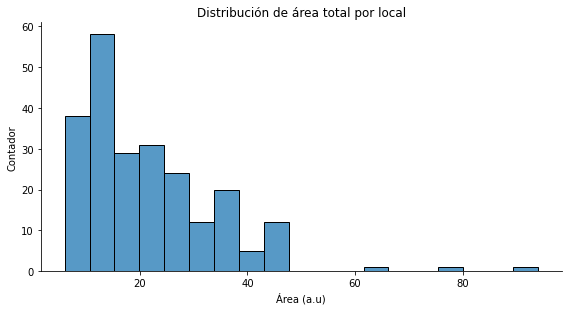

In [109]:
g = sns.displot(data=y, kde=False, height=4, aspect=2)
g.set_axis_labels("Área (a.u)","Contador")
plt.title("Distribución de área total por local");

###  ¿Están correlacionadas la hora y la venta? Cuantificar esta correlación

In [151]:
x = np.sort(df['Hora'].unique())
total = []
for i in x:
    total.append(df.loc[df['Hora'] == i, 'Ventas'].mean())

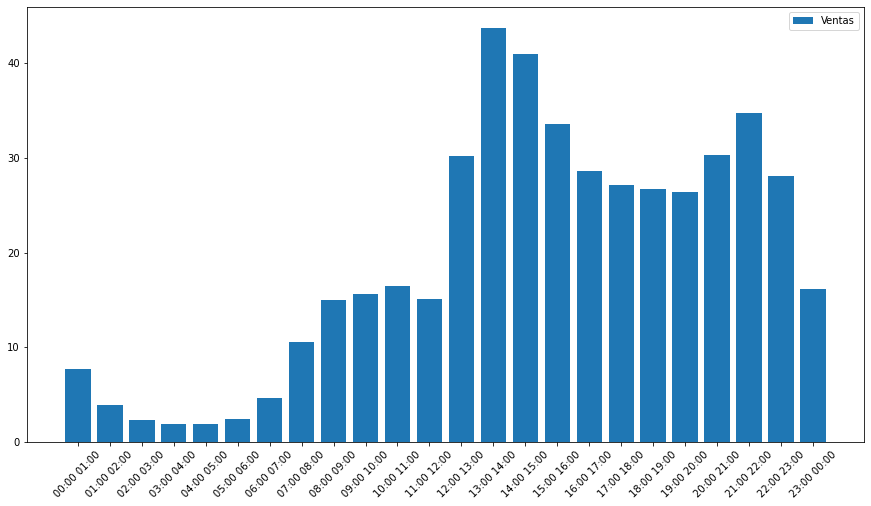

In [152]:
plt.figure(figsize=(15,8))
plt.bar(x,total, label='Ventas')
plt.xticks(rotation = 45);
plt.legend();


In [156]:
np.corrcoef(np.linspace(0.5,23.5,24),total)

array([[1.        , 0.75816191],
       [0.75816191, 1.        ]])

Entonces el coeficiente de correlación es 0.75 y nos indica que hay una correlación positiva osea que si aumenta la hora es posible que aumenten las ventas